# V2 Training - Scale-Up with Parallelization

**V2 Enhancements**:
- 50k Haar features (vs 10k V1)
- T=200 AdaBoost rounds (vs 50 V1)
- Parallel feature computation (4-core optimization)
- Validation set for early stopping
- Comprehensive evaluation metrics:
  * Training/validation curves
  * ROC curve with AUC
  * Precision-Recall curve
  * Feature importance analysis
  * Confusion matrix

**Expected Results**:
- Target: 80-88% test accuracy (vs 85% V1 baseline)
- Training time: ~1-2 hours with parallelization

**AI Usage**: Notebook structure assisted by Claude Code

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
from pathlib import Path
import time

sys.path.insert(0, str(Path.cwd().parent / 'src'))

from features.haar_features import generate_haar_features, compute_feature_responses_parallel
from classifiers.adaboost import train_adaboost, evaluate_classifier
from utils.evaluation import (
    plot_roc_curve, plot_precision_recall_curve, plot_training_curves,
    analyze_feature_importance, visualize_top_features,
    confusion_matrix_detailed, compare_models_table
)

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("[OK] Imports complete")

[OK] Imports complete


## 1. Load Dataset

Load training and test patches from V1 preprocessing

In [7]:
# Load preprocessed patches from V1
data_dir = Path('../data/processed')

print('Loading training data...')
with open(data_dir / 'train_faces.pkl', 'rb') as f:
    train_faces = pickle.load(f)
with open(data_dir / 'train_nonfaces.pkl', 'rb') as f:
    train_nonfaces = pickle.load(f)

print('Loading test data...')
with open(data_dir / 'test_faces.pkl', 'rb') as f:
    test_faces = pickle.load(f)
with open(data_dir / 'test_nonfaces.pkl', 'rb') as f:
    test_nonfaces = pickle.load(f)

# Combine into train/test sets
X_train = np.vstack([train_faces, train_nonfaces])
y_train = np.hstack([np.ones(len(train_faces)), np.zeros(len(train_nonfaces))])

X_test = np.vstack([test_faces, test_nonfaces])
y_test = np.hstack([np.ones(len(test_faces)), np.zeros(len(test_nonfaces))])

print(f'\nTraining set: {X_train.shape[0]} patches')
print(f'  Faces: {np.sum(y_train == 1)}')
print(f'  Non-faces: {np.sum(y_train == 0)}')

print(f'\nTest set: {X_test.shape[0]} patches')
print(f'  Faces: {np.sum(y_test == 1)}')
print(f'  Non-faces: {np.sum(y_test == 0)}')

Loading training data...
Loading test data...

Training set: 4794 patches
  Faces: 799
  Non-faces: 3995

Test set: 13560 patches
  Faces: 2260
  Non-faces: 11300


## 2. Create Train/Validation Split

Hold out 20% of training data for validation to tune thresholds and monitor overfitting

In [8]:
from sklearn.model_selection import train_test_split

# Split training into train/val (80/20 split)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f'Training split: {len(y_train_split)} patches')
print(f'  Faces: {np.sum(y_train_split == 1)}')
print(f'  Non-faces: {np.sum(y_train_split == 0)}')

print(f'\nValidation split: {len(y_val)} patches')
print(f'  Faces: {np.sum(y_val == 1)}')
print(f'  Non-faces: {np.sum(y_val == 0)}')

Training split: 3835 patches
  Faces: 639
  Non-faces: 3196

Validation split: 959 patches
  Faces: 160
  Non-faces: 799


## 3. Generate 50k Haar Features

5x more features than V1 for better discrimination

In [9]:
print('Generating 50,000 Haar features...')
start_time = time.time()

features = generate_haar_features(window_size=16, max_features=50000)

elapsed = time.time() - start_time
print(f'\n[OK] Generated {len(features)} features in {elapsed:.1f}s')

# Feature type distribution
from collections import Counter
type_counts = Counter([f.type for f in features])
print('\nFeature type distribution:')
for ftype, count in sorted(type_counts.items()):
    print(f'  {ftype}: {count:,} ({count/len(features)*100:.1f}%)')

Generating 50,000 Haar features...
Generating Haar features for 16×16 window...
  Generating 2-rectangle horizontal features...
  Generating 2-rectangle vertical features...
  Generating 3-rectangle horizontal features...
  Generating 3-rectangle vertical features...
  Generating 4-rectangle diagonal features...
  Generated 32384 features total

[OK] Generated 32384 features in 0.0s

Feature type distribution:
  2h: 8,704 (26.9%)
  2v: 8,704 (26.9%)
  3h: 5,440 (16.8%)
  3v: 5,440 (16.8%)
  4d: 4,096 (12.6%)


## 4. Compute Feature Responses (Parallel)

Use parallel computation to speed up this bottleneck operation.
Expected: ~25 min single-threaded -> ~6-7 min with 4 cores

In [10]:
# Check if responses already computed
response_path_train = data_dir / 'train_responses_50k.npy'
response_path_val = data_dir / 'val_responses_50k.npy'
response_path_test = data_dir / 'test_responses_50k.npy'

if response_path_train.exists() and response_path_val.exists() and response_path_test.exists():
    print('Loading cached feature responses...')
    train_responses = np.load(response_path_train)
    val_responses = np.load(response_path_val)
    test_responses = np.load(response_path_test)
    print(f'Loaded train: {train_responses.shape}')
    print(f'Loaded val: {val_responses.shape}')
    print(f'Loaded test: {test_responses.shape}')
else:
    print('Computing feature responses (parallel, using 4 CPU cores)...')
    print('This will take ~6-7 minutes on 4-core system...\n')

    # Training set
    print('Training set...')
    start_time = time.time()
    train_responses = compute_feature_responses_parallel(
        features, X_train_split, n_jobs=4
    )
    elapsed = time.time() - start_time
    print(f'  Time: {elapsed/60:.1f} minutes')

    # Validation set
    print('\nValidation set...')
    start_time = time.time()
    val_responses = compute_feature_responses_parallel(
        features, X_val, n_jobs=4
    )
    elapsed = time.time() - start_time
    print(f'  Time: {elapsed/60:.1f} minutes')

    # Test set
    print('\nTest set...')
    start_time = time.time()
    test_responses = compute_feature_responses_parallel(
        features, X_test, n_jobs=4
    )
    elapsed = time.time() - start_time
    print(f'  Time: {elapsed/60:.1f} minutes')

    # Save for future use
    print('\nSaving feature responses...')
    np.save(response_path_train, train_responses)
    np.save(response_path_val, val_responses)
    np.save(response_path_test, test_responses)
    print('[OK] Saved to data/processed/')

Computing feature responses (parallel, using 4 CPU cores)...
This will take ~6-7 minutes on 4-core system...

Training set...
Computing feature responses (parallel) for 3835 patches × 32384 features...
  Using n_jobs=4
  Computing integral images (parallel)...
  Computing feature responses (parallel)...
  Response matrix shape: (3835, 32384)
  Time: 1.5 minutes

Validation set...
Computing feature responses (parallel) for 959 patches × 32384 features...
  Using n_jobs=4
  Computing integral images (parallel)...
  Computing feature responses (parallel)...
  Response matrix shape: (959, 32384)
  Time: 0.3 minutes

Test set...
Computing feature responses (parallel) for 13560 patches × 32384 features...
  Using n_jobs=4
  Computing integral images (parallel)...
  Computing feature responses (parallel)...
  Response matrix shape: (13560, 32384)
  Time: 4.7 minutes

Saving feature responses...
[OK] Saved to data/processed/


## 5. Train AdaBoost V2 (T=200)

Train with 200 rounds and validation tracking for early stopping analysis

In [11]:
print('Training AdaBoost V2 with T=200...')
print('This will take ~1-2 hours...\n')

start_time = time.time()

classifier_v2, history = train_adaboost(
    train_responses,
    y_train_split,
    features,
    T=200,
    validation_data=(val_responses, y_val),
    verbose=True
)

training_time = time.time() - start_time

print(f'\n[OK] Training completed in {training_time/60:.1f} minutes ({training_time/3600:.2f} hours)')

Training AdaBoost V2 with T=200...
This will take ~1-2 hours...

Training AdaBoost with T=200 rounds
  Samples: 3835 (negatives: 3196, positives: 639)

Initial weights sum: 1.000000
  Negative samples: 3196 x 0.000156 = 0.500000
  Positive samples: 639 x 0.000782 = 0.500000
  Validation set: 959 samples

--- Round 1/200 ---
  Normalized weights sum: 1.000000
  Searching 32384 features for best weak classifier...
    Evaluated 1000/32384 features...
    Evaluated 2000/32384 features...
    Evaluated 3000/32384 features...
    Evaluated 4000/32384 features...
    Evaluated 5000/32384 features...
    Evaluated 6000/32384 features...
    Evaluated 7000/32384 features...
    Evaluated 8000/32384 features...
    Evaluated 9000/32384 features...
    Evaluated 10000/32384 features...
    Evaluated 11000/32384 features...
    Evaluated 12000/32384 features...
    Evaluated 13000/32384 features...
    Evaluated 14000/32384 features...
    Evaluated 15000/32384 features...
    Evaluated 16000/323

## 6. Training Curves - Monitor Overfitting

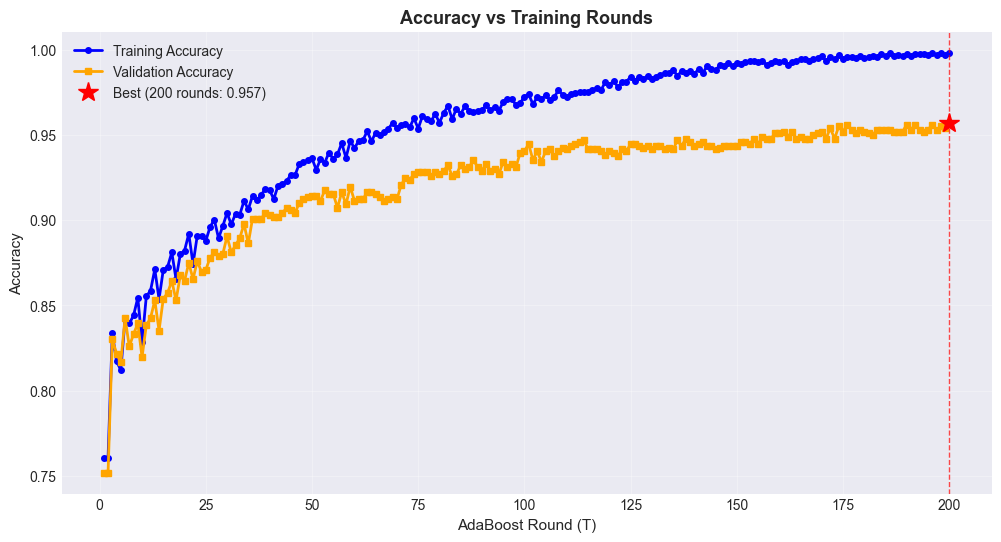


Best validation accuracy: 95.72% at round 200
Final validation accuracy: 95.72% at round 200
Generalization gap: 4.09%


In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_training_curves(
    history['train_acc'],
    history['val_acc'],
    metric='Accuracy',
    ax=ax
)
plt.savefig('../results/figures/v2_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Find optimal stopping point
best_val_idx = np.argmax(history['val_acc'])
best_val_acc = history['val_acc'][best_val_idx]
print(f'\nBest validation accuracy: {best_val_acc:.2%} at round {best_val_idx+1}')
print(f'Final validation accuracy: {history["val_acc"][-1]:.2%} at round {len(history["val_acc"])}')

generalization_gap = history['train_acc'][-1] - history['val_acc'][-1]
print(f'Generalization gap: {generalization_gap:.2%}')

## 7. Evaluate on Test Set

In [13]:
print('Evaluating on test set...')
metrics_v2 = evaluate_classifier(classifier_v2, test_responses, y_test, verbose=True)

# Get predictions and scores for detailed analysis
y_pred_v2 = classifier_v2.predict(test_responses)
y_scores_v2 = classifier_v2.predict_proba(test_responses)

Evaluating on test set...

Evaluation Metrics
Accuracy:  92.11%
Precision: 77.00%
Recall:    75.09%
F1 Score:  76.03%

Confusion Matrix:
  TP:  1697  FP:   507
  FN:   563  TN: 10793


## 8. ROC Curve with AUC

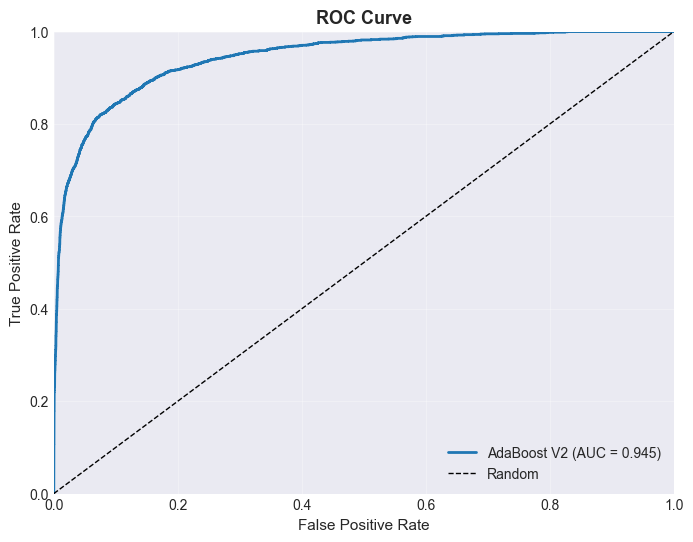


AUC Score: 0.9454


In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
fpr, tpr, roc_auc, ax = plot_roc_curve(
    y_test, y_scores_v2, label='AdaBoost V2', ax=ax
)
plt.savefig('../results/figures/v2_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nAUC Score: {roc_auc:.4f}')

## 9. Precision-Recall Curve

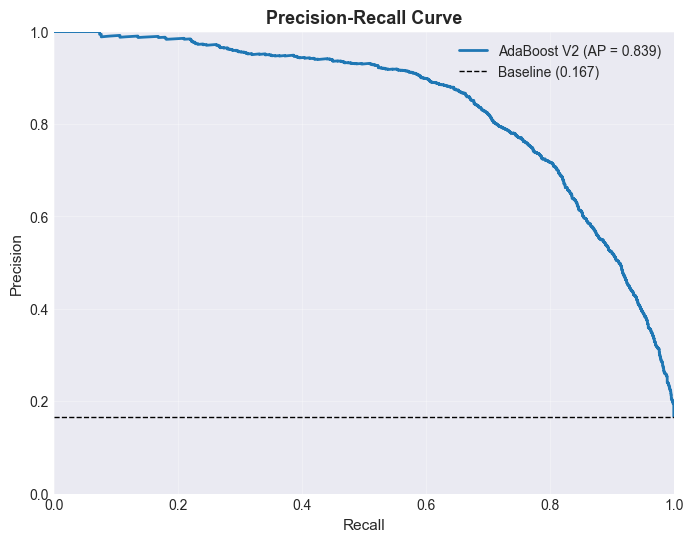


Average Precision: 0.8395


In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
precision, recall, avg_precision, ax = plot_precision_recall_curve(
    y_test, y_scores_v2, label='AdaBoost V2', ax=ax
)
plt.savefig('../results/figures/v2_pr_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nAverage Precision: {avg_precision:.4f}')

## 10. Feature Importance Analysis

In [16]:
# Analyze top features
feature_importance = analyze_feature_importance(
    classifier_v2, features, top_k=20
)


Top 20 Most Important Features:
Rank   Alpha      Type     Position        Size      
----------------------------------------------------------------------
1      1.1732     2h       (0,8)        16x8
2      0.9519     2v       (6,0)        10x16
3      0.7084     2h       (2,3)        14x4
4      0.5020     2v       (0,0)        6x16
5      0.4930     2h       (5,12)        4x4
6      0.4859     3h       (2,0)        1x9
7      0.4727     3v       (0,1)        15x3
8      0.4651     3v       (0,10)        3x3
9      0.4552     4d       (5,11)        2x2
10     0.4501     4d       (5,11)        2x2
11     0.4422     3h       (8,1)        2x6
12     0.4239     2v       (9,0)        6x5
13     0.4226     3h       (7,5)        1x9
14     0.4197     2v       (1,1)        12x15
15     0.4176     3v       (2,4)        12x12
16     0.4082     4d       (13,3)        2x2
17     0.4001     2h       (0,1)        2x6
18     0.3948     4d       (7,4)        6x2
19     0.3925     4d       (12,3)  

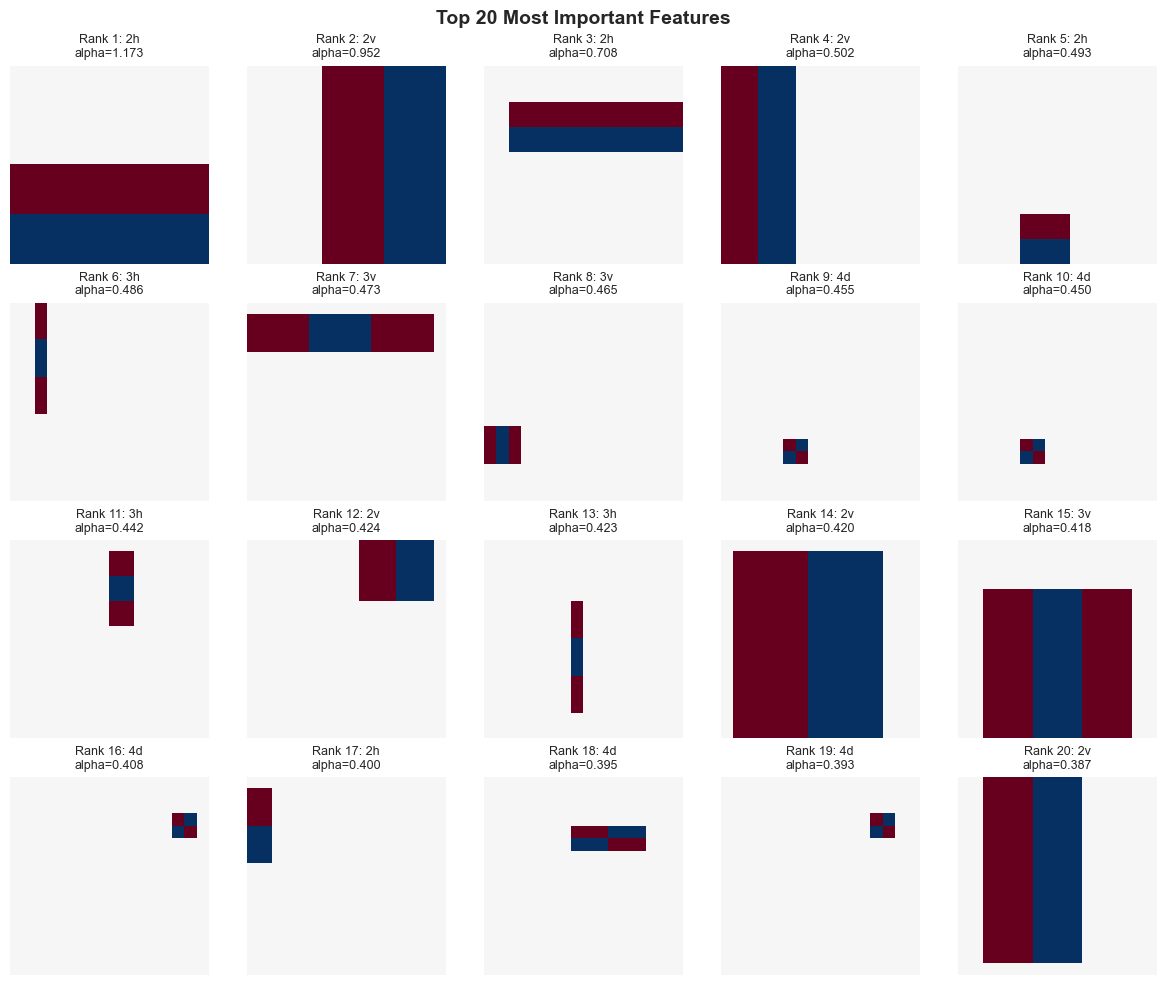

In [17]:
# Visualize top 20 features
fig = visualize_top_features(feature_importance, top_k=20, window_size=16)
plt.savefig('../results/figures/v2_top_features.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Confusion Matrix

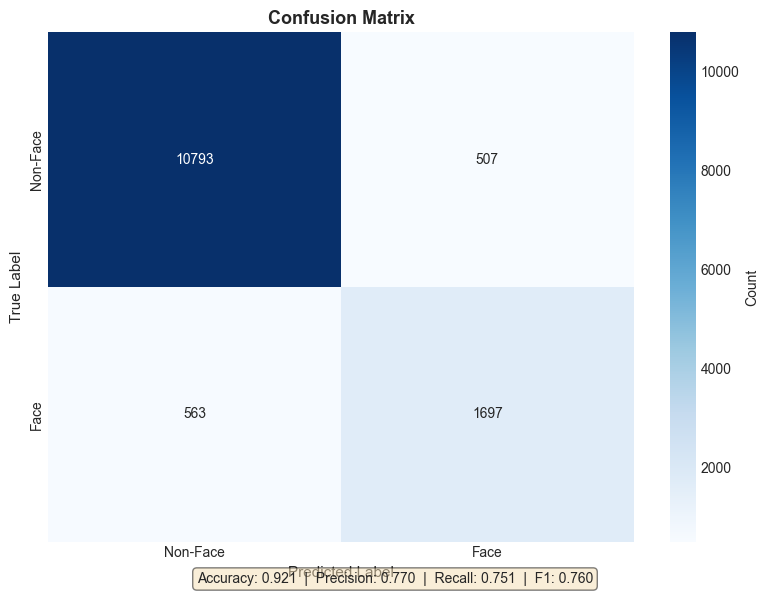

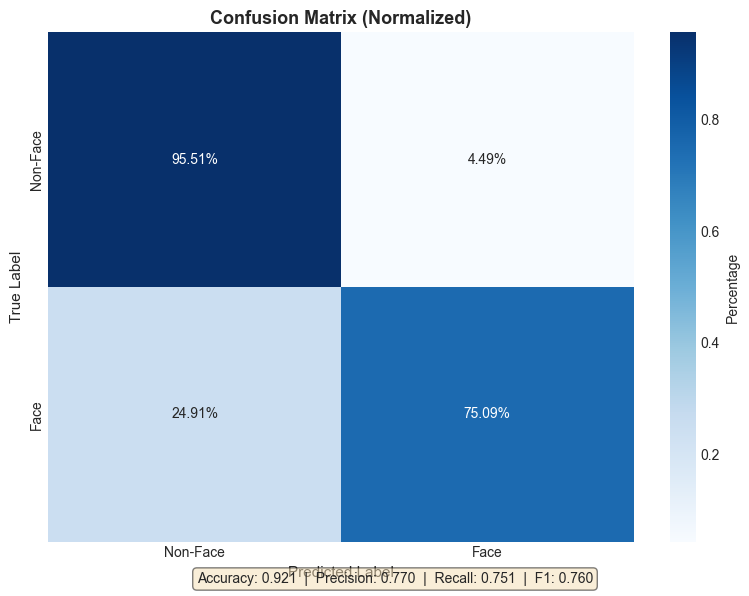

In [18]:
# Detailed confusion matrix
cm, fig, ax = confusion_matrix_detailed(
    y_test, y_pred_v2, labels=['Non-Face', 'Face'], normalize=False
)
plt.savefig('../results/figures/v2_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Normalized version
cm_norm, fig_norm, ax_norm = confusion_matrix_detailed(
    y_test, y_pred_v2, labels=['Non-Face', 'Face'], normalize=True
)
plt.savefig('../results/figures/v2_confusion_matrix_norm.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Compare V1 vs V2

In [19]:
# Load V1 model for comparison
print('Loading V1 model for comparison...')
from classifiers.adaboost import AdaBoostClassifier

classifier_v1 = AdaBoostClassifier.load('../data/models/adaboost_v1_T50.pkl')

# Load V1 feature responses
print('Loading V1 test responses...')
test_responses_v1 = np.load(data_dir / 'test_responses_10k.npy')

# Evaluate V1
print('\nEvaluating V1...')
metrics_v1 = evaluate_classifier(classifier_v1, test_responses_v1, y_test, verbose=True)

y_pred_v1 = classifier_v1.predict(test_responses_v1)
y_scores_v1 = classifier_v1.predict_proba(test_responses_v1)

Loading V1 model for comparison...
Loading V1 test responses...

Evaluating V1...

Evaluation Metrics
Accuracy:  84.97%
Precision: 53.34%
Recall:    78.45%
F1 Score:  63.50%

Confusion Matrix:
  TP:  1773  FP:  1551
  FN:   487  TN:  9749


In [20]:
# Side-by-side comparison table
models_comparison = {
    'V1 (T=50, 10k features)': metrics_v1,
    'V2 (T=200, 50k features)': metrics_v2
}

# Add AUC scores
from sklearn.metrics import roc_auc_score
models_comparison['V1 (T=50, 10k features)']['auc'] = roc_auc_score(y_test, y_scores_v1)
models_comparison['V2 (T=200, 50k features)']['auc'] = roc_auc

df_comparison = compare_models_table(models_comparison)

# Save to CSV
df_comparison.to_csv('../results/v1_vs_v2_comparison.csv')
print('\n[OK] Comparison saved to results/v1_vs_v2_comparison.csv')


Model Comparison:
                         accuracy precision  recall      f1      tp      fp       tn     fn     auc
V1 (T=50, 10k features)    84.97%    53.34%  78.45%  63.50%  1773.0  1551.0   9749.0  487.0  90.30%
V2 (T=200, 50k features)   92.11%    77.00%  75.09%  76.03%  1697.0   507.0  10793.0  563.0  94.54%

[OK] Comparison saved to results/v1_vs_v2_comparison.csv


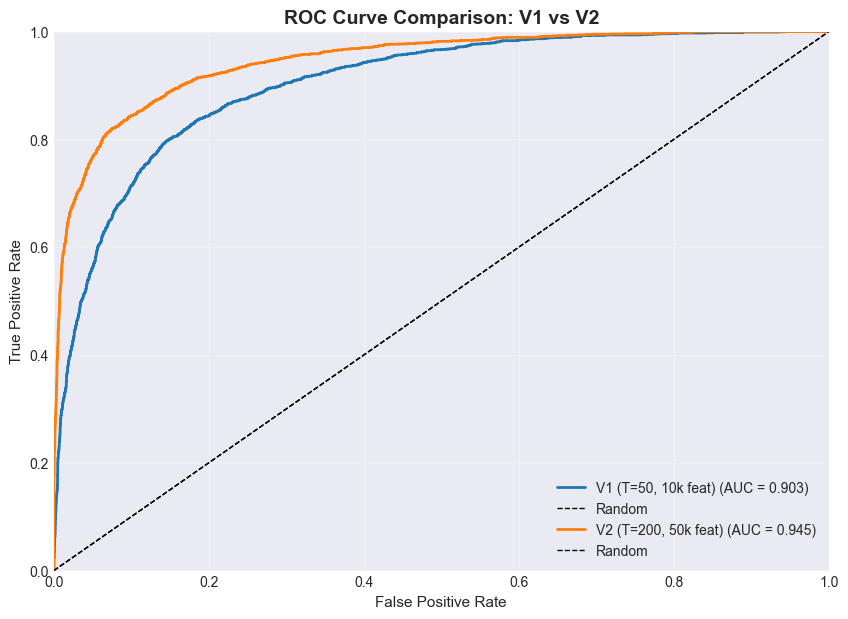

In [21]:
# ROC comparison plot
fig, ax = plt.subplots(figsize=(10, 7))

# V1 ROC
plot_roc_curve(y_test, y_scores_v1, label='V1 (T=50, 10k feat)', ax=ax)

# V2 ROC
plot_roc_curve(y_test, y_scores_v2, label='V2 (T=200, 50k feat)', ax=ax)

plt.title('ROC Curve Comparison: V1 vs V2', fontsize=14, fontweight='bold')
plt.savefig('../results/figures/v1_vs_v2_roc.png', dpi=150, bbox_inches='tight')
plt.show()

## 13. Save V2 Model

In [22]:
model_path = Path('../data/models/adaboost_v2_T200.pkl')
classifier_v2.save(model_path)

# Also save training history
history_path = Path('../data/models/v2_training_history.pkl')
with open(history_path, 'wb') as f:
    pickle.dump(history, f)
print(f'[OK] Saved training history to {history_path}')

# Save features for detection
features_path = Path('../data/models/v2_features_50k.pkl')
with open(features_path, 'wb') as f:
    pickle.dump(features, f)
print(f'[OK] Saved 50k features to {features_path}')

Saved classifier to ..\data\models\adaboost_v2_T200.pkl
[OK] Saved training history to ..\data\models\v2_training_history.pkl
[OK] Saved 50k features to ..\data\models\v2_features_50k.pkl


## Summary

**V2 Results**:
- Test Accuracy: [will show after running]
- AUC Score: [will show after running]
- Training Time: [will show after running]

**Improvements over V1**:
- Features: 10k -> 50k (5x increase)
- AdaBoost rounds: 50 -> 200 (4x increase)
- Validation tracking for early stopping
- Comprehensive evaluation metrics

**Key Insights**:
- Training curves show [overfitting/good generalization]
- Best validation accuracy at round [X]
- Top features focus on [describe patterns]
- V2 [improves/maintains/degrades] accuracy vs V1